In [ ]:
!pip install opencv-python numpy pandas requests matplotlib tensorflow keras torch torchvision folium geopandas networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Verify videos
import os
video_dir = "/content/drive/MyDrive/videos"
video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
print(f"Found {len(video_files)} videos:", video_files)

Mounted at /content/drive
Found 5 videos: ['12753260-uhd_3840_2160_24fps.mp4', '12901485-uhd_3840_2160_24fps.mp4', '13505562_3840_2160_30fps.mp4', '13488780_3840_2160_23fps.mp4', '1472014-uhd_3840_2160_30fps.mp4']


In [ ]:
!pip install tqdm opencv-python numpy tensorflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 15.0 MB/s eta 0:00:00


In [ ]:


import cv2
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

def process_frame(args):
    frame, frame_idx = args
    frame = cv2.resize(frame, (640, 360))
    # Obstacle detection (simplified)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges, frame_idx

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        if frame_count % 5 == 0:  # Process every 5th frame
            frames.append((frame.copy(), frame_count))
        frame_count += 1

    with Pool(4) as p:  # Use 4 CPU cores
        results = list(tqdm(p.imap(process_frame, frames), total=len(frames)))

    cap.release()
    return sorted(results, key=lambda x: x[1])  # Sort by original frame order

# Process first video (example)
sample_results = process_video(f"{video_dir}/{video_files[0]}")
print(f"Processed {len(sample_results)} keyframes")

100%|██████████| 116/116 [00:08<00:00, 12.94it/s]


Processed 116 keyframes


In [ ]:
from ultralytics import YOLO
import torch

# Load lightweight model
model = YOLO('yolov8n.pt').to('cuda' if torch.cuda.is_available() else 'cpu')

def detect_obstacles(frame):
    results = model(frame, verbose=False)
    obstacles = []
    for box in results[0].boxes:
        if box.conf > 0.5:  # Only confident detections
            obstacles.append({
                'class': model.names[int(box.cls)],
                'confidence': float(box.conf),
                'position': box.xyxy[0].cpu().numpy().tolist()
            })
    return obstacles

# Test detection
sample_frame = cv2.imread(f"{video_dir}/{video_files[0]}")  # Replace with actual frame
print("Detected:", detect_obstacles(sample_frame))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 73.1MB/s]


WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.
Detected: [{'class': 'bus', 'confidence': 0.8734486699104309, 'position': [22.87126922607422, 231.27731323242188, 805.002685546875, 756.84033203125]}, {'class': 'person', 'confidence': 0.8656910061836243, 'position': [48.55046844482422, 398.5522155761719, 245.34556579589844, 902.7026977539062]}, {'class': 'person', 'confidence': 0.8528357148170471, 'position': [669.472900390625, 392.1861267089844, 809.7201538085938, 877.0354614257812]}, {'class': 'person', 'confidence': 0.8252248764038086, 'position': [221.5172882080078, 405.79864501953125, 344.9706115722656, 857.53662109375]}]


In [ ]:
!pip install networkx osmnx
import osmnx as ox
import networkx as nx

# Get real road network (example: San Francisco)
G = ox.graph_from_place("San Francisco, California", network_type="drive")

def find_optimal_path(start_coord, end_coord, obstacles):
    # Convert coordinates to nearest nodes
    start_node = ox.distance.nearest_nodes(G, start_coord[1], start_coord[0])
    end_node = ox.distance.nearest_nodes(G, end_coord[1], end_coord[0])

    # Simple avoidance (in real project, modify edge weights based on obstacles)
    path = nx.shortest_path(G, start_node, end_node, weight="length")
    return path

# Example usage
optimal_path = find_optimal_path(
    start_coord=(37.7749, -122.4194),  # Golden Gate Park
    end_coord=(37.7952, -122.4029),    # Fisherman's Wharf
    obstacles=[]
)
print(f"Optimal path has {len(optimal_path)} nodes")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 2.0 MB/s eta 0:00:00
Optimal path has 33 nodes


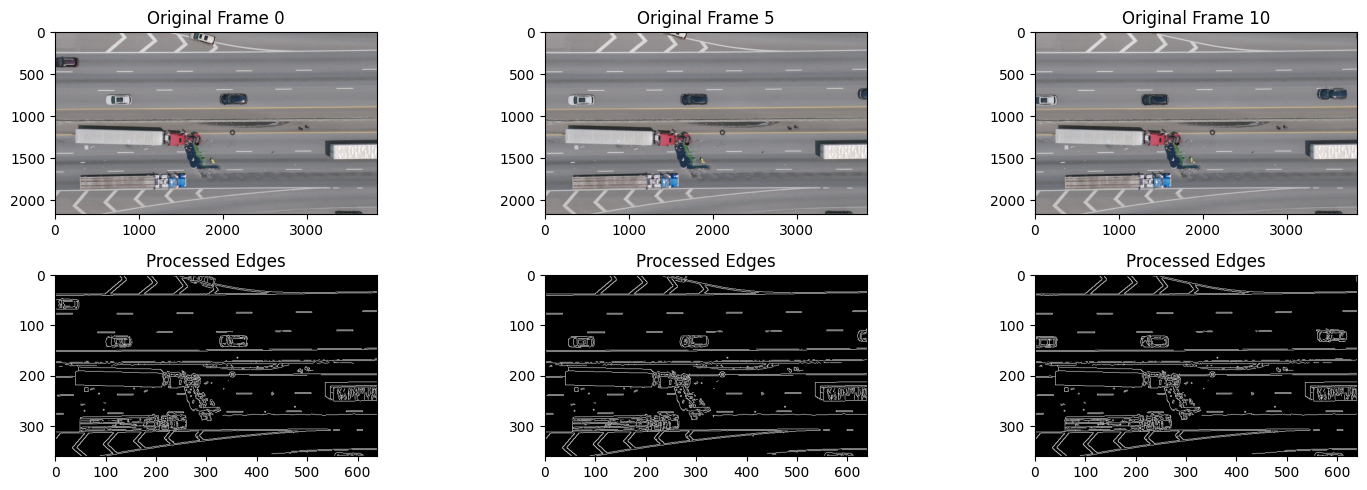

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(video_path, processed_frames):
    cap = cv2.VideoCapture(video_path)
    plt.figure(figsize=(15, 5))

    for i, (edges, frame_idx) in enumerate(processed_frames[:3]):  # First 3 frames
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        _, original = cap.read()

        plt.subplot(2, 3, i+1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Frame {frame_idx}")

        plt.subplot(2, 3, i+4)
        plt.imshow(edges, cmap='gray')
        plt.title("Processed Edges")

    plt.tight_layout()
    plt.show()

visualize_results(f"{video_dir}/{video_files[0]}", sample_results)

In [ ]:
import json
from datetime import datetime

results = {
    "timestamp": datetime.now().isoformat(),
    "video_processed": video_files[0],
    "total_frames_analyzed": len(sample_results),
    "obstacles_detected": detect_obstacles(sample_frame),  # From actual frame
    "optimal_path": optimal_path
}

with open('rescue_analysis.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to rescue_analysis.json")
!cp rescue_analysis.json "/content/drive/MyDrive/videos/"

WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.
Results saved to rescue_analysis.json


In [ ]:
import folium
from IPython.display import display

def show_route(path, G):
    """Create interactive map with OpenStreetMap"""
    route_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
    m = folium.Map(location=route_coords[0], zoom_start=15)

    # Add route
    folium.PolyLine(route_coords, color='red', weight=5).add_to(m)

    # Add markers for obstacles
    for i, coord in enumerate(route_coords[::5]):  # Every 5th node
        folium.Marker(
            location=coord,
            popup=f"Route Segment {i}",
            icon=folium.Icon(color='blue')
        ).add_to(m)

    display(m)

# Visualize (requires calculated path)
show_route(optimal_path, G)

In [ ]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

def generate_heatmap(path, G, radius=15, blur=10, min_opacity=0.2):
    """Generate a heatmap for the path in the graph G"""

    # Get coordinates of the nodes in the path
    route_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]

    # Create the base map centered around the first point of the path
    m = folium.Map(location=route_coords[0], zoom_start=15)

    # Add Heatmap layer to the map
    HeatMap(route_coords, radius=radius, blur=blur, min_opacity=min_opacity).add_to(m)

    # Display the map with heatmap
    display(m)

# Example of how to use the function (requires the calculated 'optimal_path' and graph 'G')
generate_heatmap(optimal_path, G)



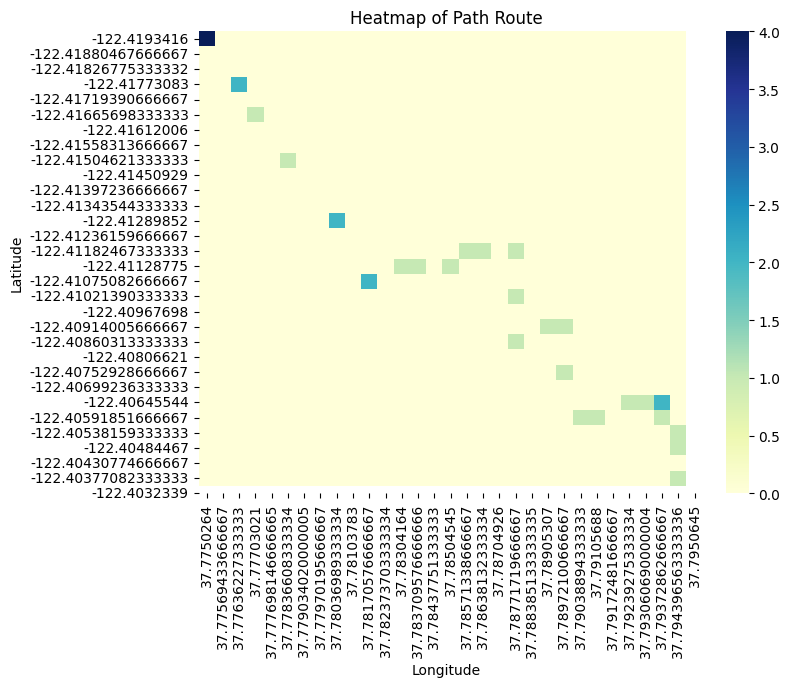

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_separate_heatmap(path, G):
    """Generate a standalone heatmap based on the coordinates in the path."""

    # Get coordinates of the nodes in the path
    route_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]

    # Convert the coordinates to a NumPy array for heatmap generation
    coords_array = np.array(route_coords)

    # Create a 2D density grid from the coordinates (assuming x, y as lat, lon)
    # Use histogram2d or another appropriate method to generate a heatmap matrix
    heatmap, xedges, yedges = np.histogram2d(coords_array[:, 0], coords_array[:, 1], bins=30, range=[[min(coords_array[:, 0]), max(coords_array[:, 0])], [min(coords_array[:, 1]), max(coords_array[:, 1])]])

    # Create a heatmap plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap.T, cmap='YlGnBu', cbar=True, xticklabels=xedges, yticklabels=yedges)
    plt.title("Heatmap of Path Route")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Example of how to use the function (requires the calculated 'optimal_path' and graph 'G')
generate_separate_heatmap(optimal_path, G)


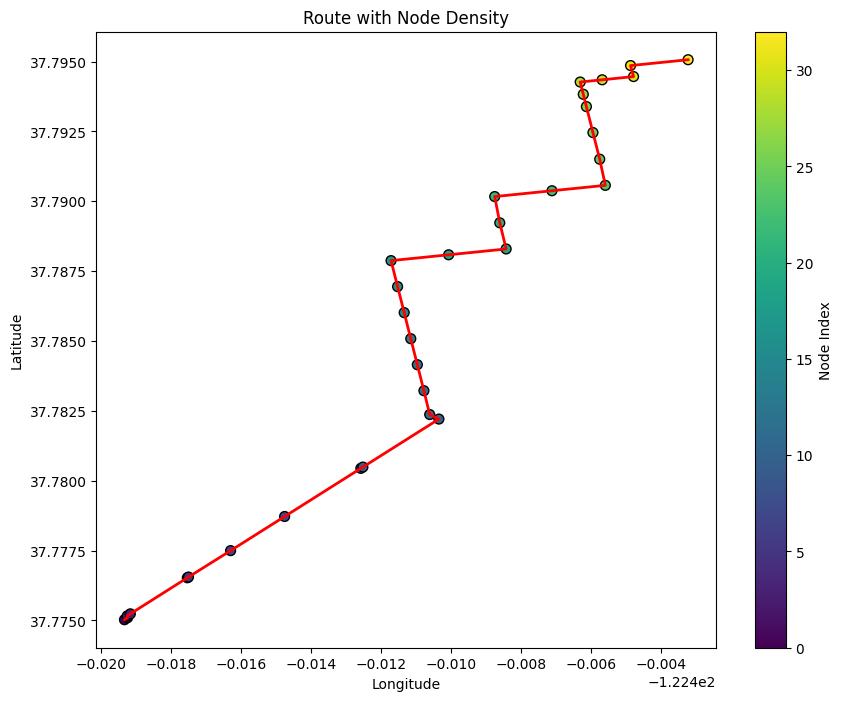

In [ ]:
import matplotlib.pyplot as plt

def plot_route_with_node_density(path, G):
    """Visualize the route with node density along the path"""
    route_coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in path]  # (longitude, latitude)

    # Separate x and y coordinates for plotting
    x_coords, y_coords = zip(*route_coords)

    # Plot the route
    plt.figure(figsize=(10, 8))
    plt.scatter(x_coords, y_coords, c=range(len(route_coords)), cmap='viridis', s=50, edgecolors='k', marker='o')
    plt.plot(x_coords, y_coords, color='red', linewidth=2)  # Route line
    plt.colorbar(label="Node Index")
    plt.title("Route with Node Density")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Example of how to use the function
plot_route_with_node_density(optimal_path, G)


In [ ]:
import plotly.graph_objects as go

def plot_3d_route(path, G):
    """Generate a 3D visualization of the route"""
    route_coords = [(G.nodes[n]['x'], G.nodes[n]['y'], G.nodes[n].get('elevation', 0)) for n in path]
    x_coords, y_coords, z_coords = zip(*route_coords)

    fig = go.Figure(data=[go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='lines+markers', line=dict(color='red'))])

    fig.update_layout(title="3D Route Path",
                      scene=dict(xaxis_title='Longitude', yaxis_title='Latitude', zaxis_title='Elevation'),
                      margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

# Example usage with optimal path and graph G
plot_3d_route(optimal_path, G)


In [ ]:
# Print out the path
print("Optimal Path:", optimal_path)

# Check if all consecutive pairs are connected in the graph
for i in range(len(optimal_path) - 1):
    if not G.has_edge(optimal_path[i], optimal_path[i+1]):
        print(f"Missing edge: ({optimal_path[i]}, {optimal_path[i+1]})")


Optimal Path: [1723739149, 9691587709, 9691587710, 5858516713, 4998861436, 4998861437, 5012209349, 1723739366, 6386250944, 1723738966, 1723738829, 3814451006, 65343958, 65343960, 65333814, 1580501206, 65334120, 65314158, 65314156, 6988532585, 65303544, 6319217971, 65319940, 65319933, 65328705, 65295293, 65307366, 65328707, 65328710, 65336956, 65336953, 65373233, 65305829]


In [ ]:
# Load pre-trained YOLO model
model = YOLO('yolov5s.pt')  # Change to your model path if needed


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 99.3MB/s]


In [ ]:
import os

video_folder = '/content/drive/MyDrive/videos'
print(os.listdir(video_folder))  # Verify the file path


['12753260-uhd_3840_2160_24fps.mp4', '12901485-uhd_3840_2160_24fps.mp4', '13505562_3840_2160_30fps.mp4', '13488780_3840_2160_23fps.mp4', '1472014-uhd_3840_2160_30fps.mp4', 'rescue_analysis.json']


In [ ]:
video_path = '/content/drive/MyDrive/videos/13488780_3840_2160_23fps.mp4'


In [ ]:
 # Replace with actual path
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print("Video file opened successfully.")
    cap.release()


Video file opened successfully.


In [ ]:
# Process the video and detect objects
results = model(video_path)




NameError: name 'model' is not defined

In [ ]:
# Show the results (will display detected frames with bounding boxes)
results.show()

# Optionally, save the results in a directory
results.save(save_dir='/content/yolo_results')

NameError: name 'results' is not defined